In [1]:
import os
import re
import warnings

import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import spacy
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
# import xgboost as xgb

In [2]:
warnings.filterwarnings("ignore")

In [3]:
df = pd.read_csv("ai_task_management_5000tasks.csv")
print(f"Dataset loaded: {df.shape[0]} tasks, {df['task_name'].nunique()} task_name")

Dataset loaded: 5000 tasks, 20 task_name


In [4]:
#Dataset Overview

print("Dataset shape:", df.shape)
print("\nColumns:\n", df.columns)
print("\nInfo:")
print(df.info())
print("\nMissing values:\n", df.isna().sum())

print("\n Duplicate rows:", df.duplicated().sum())

Dataset shape: (5000, 11)

Columns:
 Index(['task_id', 'task_name', 'assigned_to', 'department', 'priority',
       'status', 'created_date', 'due_date', 'estimated_hours', 'actual_hours',
       'tags'],
      dtype='object')

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   task_id          5000 non-null   int64  
 1   task_name        5000 non-null   object 
 2   assigned_to      5000 non-null   object 
 3   department       5000 non-null   object 
 4   priority         5000 non-null   object 
 5   status           5000 non-null   object 
 6   created_date     5000 non-null   object 
 7   due_date         5000 non-null   object 
 8   estimated_hours  5000 non-null   int64  
 9   actual_hours     1019 non-null   float64
 10  tags             5000 non-null   object 
dtypes: float64(1), int64(2), object(8)
memory usage: 429.8+ 

In [5]:
df.fillna({'actual_hours': df['actual_hours'].median()}, inplace=True)
df.fillna('', inplace=True)

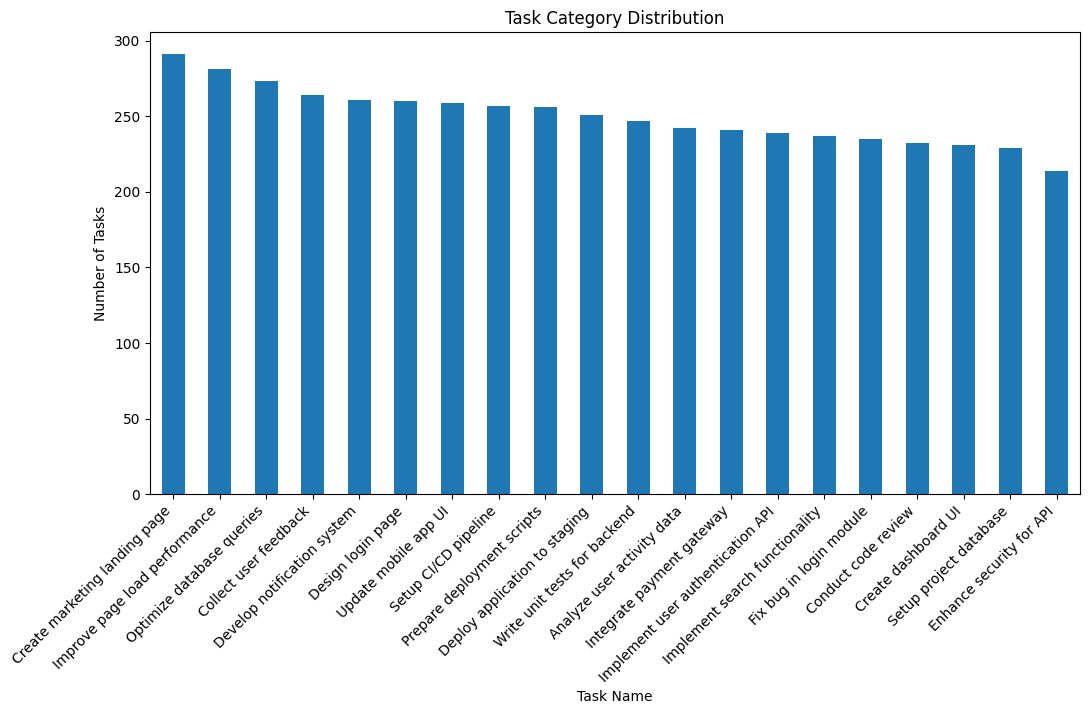

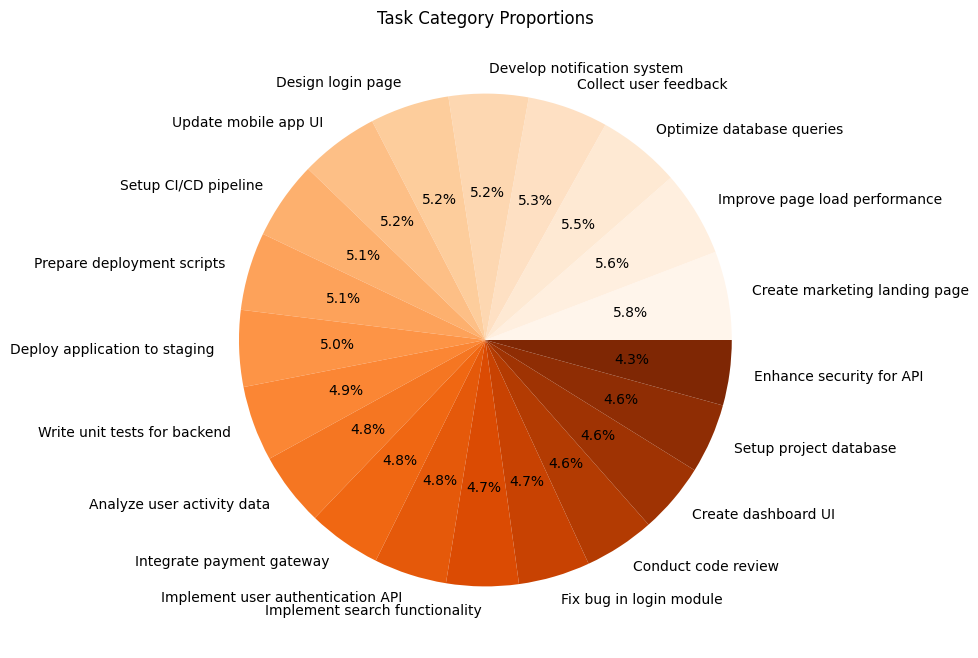

In [6]:
#Task Name Analysis-

plt.figure(figsize=(12,6))
df['task_name'].value_counts().plot(kind='bar')
plt.title("Task Category Distribution")
plt.ylabel("Number of Tasks")
plt.xlabel("Task Name")
plt.xticks(rotation=45, ha='right')
plt.show()

# Pie chart (corrected labels and colors)
counts = df['task_name'].value_counts()
labels = counts.index
colors = plt.cm.Oranges(np.linspace(0, 1, len(counts)))
plt.figure(figsize=(12,8))
plt.pie(counts, labels=labels, autopct='%1.1f%%', colors=colors)
plt.title("Task Category Proportions")
plt.show()

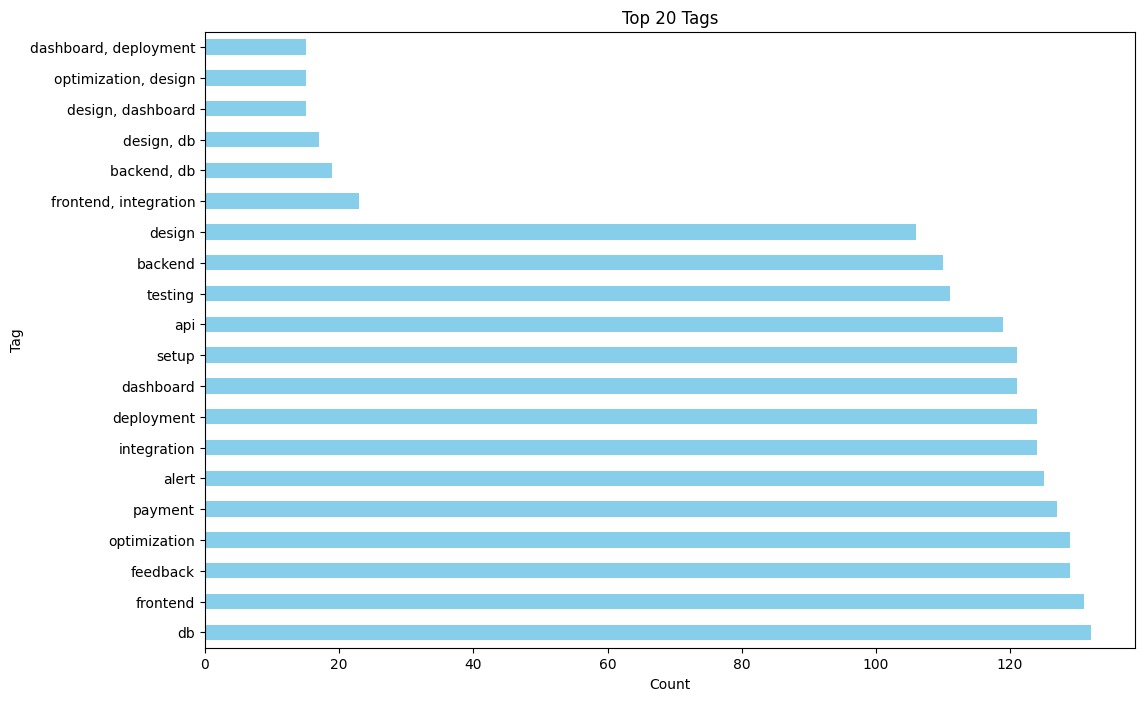

In [7]:
#Tag Analysis
if 'tags' in df.columns:
    plt.figure(figsize=(12,8))
    df['tags'].value_counts().head(20).plot(kind='barh', color='skyblue')
    plt.title("Top 20 Tags")
    plt.xlabel("Count")
    plt.ylabel("Tag")
    plt.show()

In [8]:
df['created_date'] = pd.to_datetime(df['created_date'], dayfirst=True)
df['due_date'] = pd.to_datetime(df['due_date'], dayfirst=True)
df['days_until_due'] = (df['due_date'] - df['created_date']).dt.days

In [9]:
nlp = spacy.load("en_core_web_sm")

def clean_and_lemmatize(text):
    text = str(text).lower()
    text = re.sub(r"[^a-zA-Z\s]", " ", text)
    doc = nlp(text)
    tokens = [token.lemma_ for token in doc if not token.is_stop and not token.is_punct and len(token.lemma_)>2]
    return " ".join(tokens)

df['combined_text'] = (df['task_name'] + " " + df['department'] + " " + df['tags']).apply(clean_and_lemmatize)

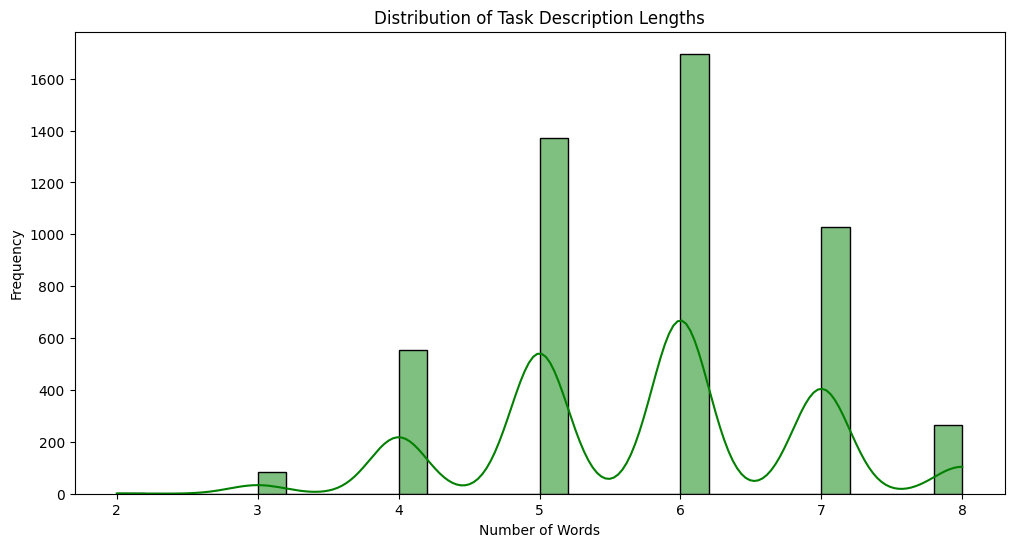

In [10]:
#Text Length Analysis
df['task_length'] = df['combined_text'].apply(lambda x: len(str(x).split()))
plt.figure(figsize=(12,6))
sns.histplot(df['task_length'], bins=30, kde=True, color='green')
plt.title("Distribution of Task Description Lengths")
plt.xlabel("Number of Words")
plt.ylabel("Frequency")
plt.show()

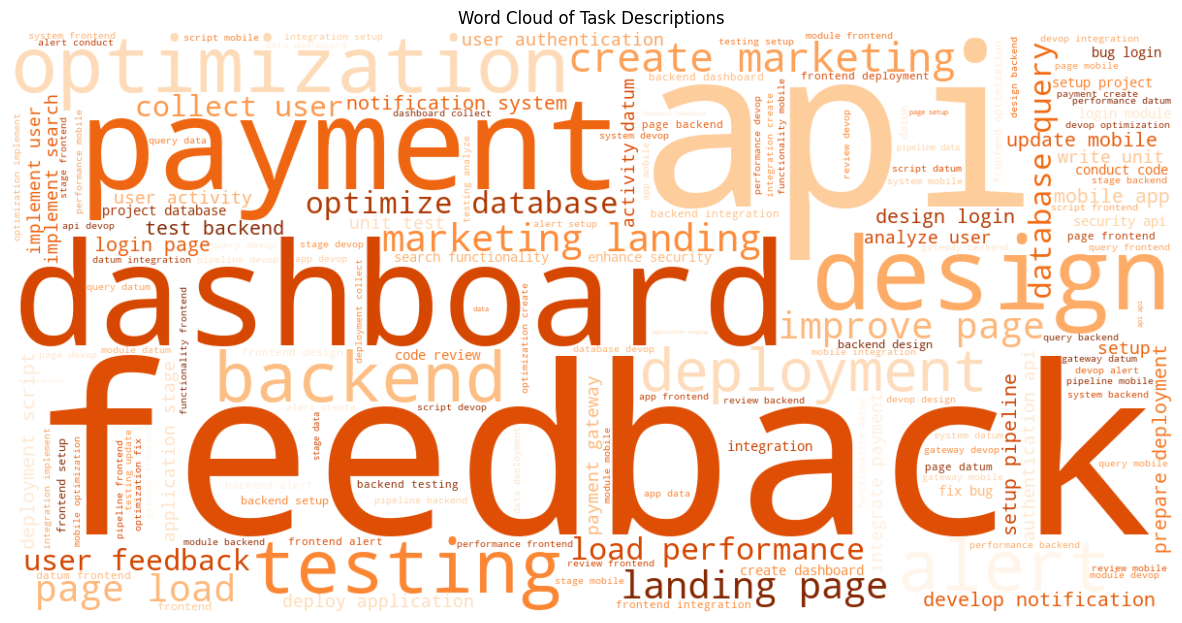

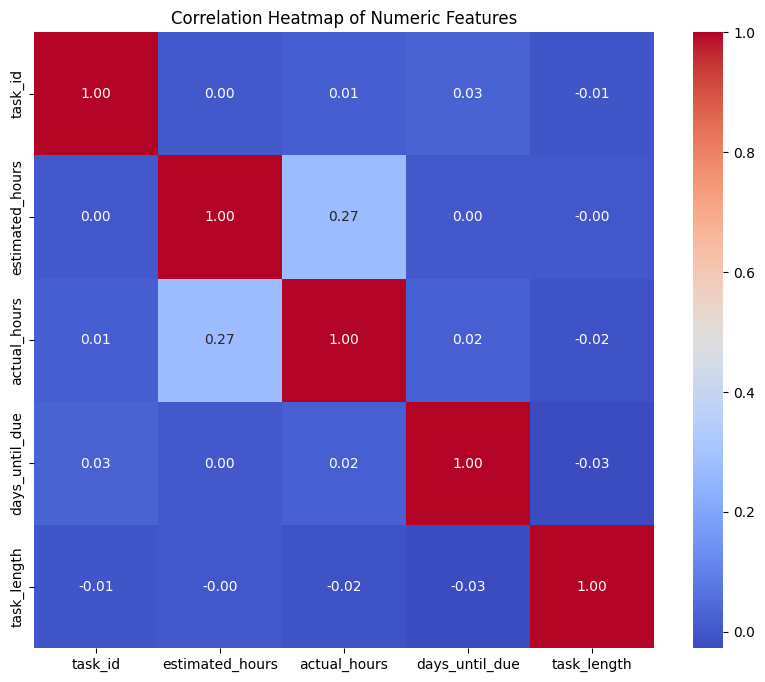

In [11]:
from wordcloud import WordCloud

all_text = " ".join(df['combined_text'])
wordcloud = WordCloud(width=1200, height=600, background_color='white', colormap='Oranges').generate(all_text)
plt.figure(figsize=(15,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud of Task Descriptions")
plt.show()


#Optional: Correlation for numeric features
numeric_cols = df.select_dtypes(include=np.number).columns
if len(numeric_cols) > 1:
    plt.figure(figsize=(10,8))
    sns.heatmap(df[numeric_cols].corr(), annot=True, cmap='coolwarm', fmt=".2f")
    plt.title("Correlation Heatmap of Numeric Features")
    plt.show()

In [12]:
task_le = LabelEncoder()
df['task_label'] = task_le.fit_transform(df['task_name'])

priority_le = LabelEncoder()
df['priority_label'] = priority_le.fit_transform(df['priority'])

user_le = LabelEncoder()
df['user_label'] = user_le.fit_transform(df['assigned_to'])

In [13]:
# TF-IDF Features
tfidf = TfidfVectorizer(max_features=3000, ngram_range=(1,2))
X_text = tfidf.fit_transform(df['combined_text'])

In [14]:
# # task classification

y_taskname = df['task_label']

# Split data
X_train_t, X_test_t, y_train_t, y_test_t = train_test_split(
    X_text, y_taskname, test_size=0.2, random_state=42, stratify=y_taskname
)

print(
    f"Taskname Model: Training: {X_train_t.shape[0]} samples, Testing: {X_test_t.shape[0]} samples"
)

Taskname Model: Training: 4000 samples, Testing: 1000 samples


Naive Bayes (Task Name)
Accuracy : 1.0000
Precision: 1.0000
Recall   : 1.0000
F1 Score : 1.0000



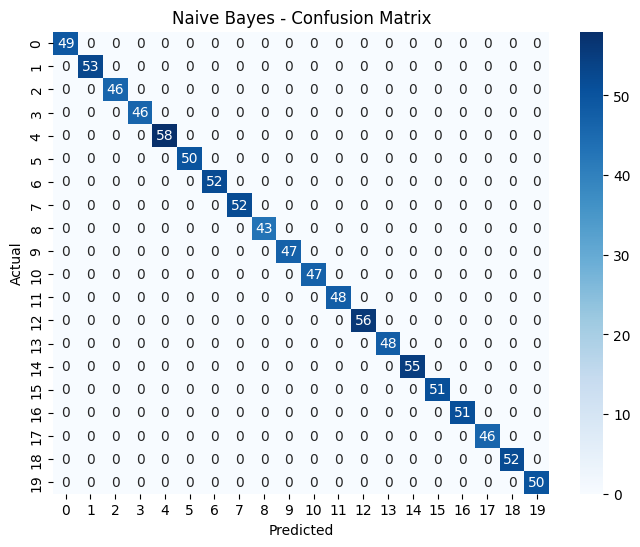

In [15]:
# Naive Bayes
nb_model = MultinomialNB()
nb_model.fit(X_train_t, y_train_t)
y_pred_nb = nb_model.predict(X_test_t)

print("Naive Bayes (Task Name)")
print(f"Accuracy : {accuracy_score(y_test_t, y_pred_nb):.4f}")
print(f"Precision: {precision_score(y_test_t, y_pred_nb, average='weighted'):.4f}")
print(f"Recall   : {recall_score(y_test_t, y_pred_nb, average='weighted'):.4f}")
print(f"F1 Score : {f1_score(y_test_t, y_pred_nb, average='weighted'):.4f}\n")

#confusion matrix
cm_nb = confusion_matrix(y_test_t, y_pred_nb)
plt.figure(figsize=(8,6))
sns.heatmap(cm_nb, annot=True, fmt="d", cmap="Blues")
plt.title("Naive Bayes - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

SVM 
Accuracy : 1.0000
Precision: 1.0000
Recall   : 1.0000
F1 Score : 1.0000



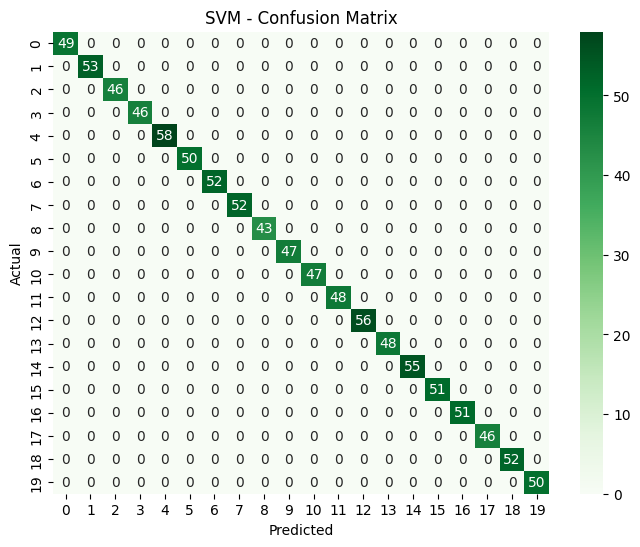

In [16]:
#Support Vector Machine (Linear)
svm_model = SVC(kernel='linear', probability=True, random_state=42)
svm_model.fit(X_train_t, y_train_t)
y_pred_svm = svm_model.predict(X_test_t)

print("SVM ")
print(f"Accuracy : {accuracy_score(y_test_t, y_pred_svm):.4f}")
print(f"Precision: {precision_score(y_test_t, y_pred_svm, average='weighted'):.4f}")
print(f"Recall   : {recall_score(y_test_t, y_pred_svm, average='weighted'):.4f}")
print(f"F1 Score : {f1_score(y_test_t, y_pred_svm, average='weighted'):.4f}\n")

#confusion matrix
cm_svm = confusion_matrix(y_test_t, y_pred_svm)
plt.figure(figsize=(8,6))
sns.heatmap(cm_svm, annot=True, fmt="d", cmap="Greens")
plt.title("SVM - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [17]:
new_task = "Deploy the application to the staging environment to test its functionality, performance, and integration in a production-like setting before the final release"

new_task_cleaned = clean_and_lemmatize(new_task)
print(f"Cleaned text: {new_task_cleaned}")

new_task_tfidf = tfidf.transform([new_task_cleaned])

Cleaned text: deploy application staging environment test functionality performance integration production like set final release


In [18]:
# Using Naive Bayes
pred_nb = nb_model.predict(new_task_tfidf)
pred_task_nb = task_le.inverse_transform(pred_nb)
print(f"Naive Bayes Prediction: {pred_task_nb[0]}")

# Using SVM
pred_svm = svm_model.predict(new_task_tfidf)
pred_task_svm = task_le.inverse_transform(pred_svm)
print(f"SVM Prediction: {pred_task_svm[0]}")

Naive Bayes Prediction: Deploy application to staging
SVM Prediction: Deploy application to staging
